## Script to Find and List Files in a Directory

In [1]:
import os
import glob

def find_tsv_files(directory):
    search_pattern = os.path.join(directory, '*.tsv')
    tsv_files = glob.glob(search_pattern)
    updated_files = [t.replace("\\", "/") for t in tsv_files]
    tsv_dict = {os.path.splitext(os.path.basename(t))[0]: t for t in updated_files}
    return tsv_dict
    
directory_path = '../Dataset/'
tsv_dict = find_tsv_files(directory_path)

for file_name, file_path in tsv_dict.items():
    print(f"{file_name}: {file_path}")

contacts: ../Dataset/contacts.tsv
content: ../Dataset/content.tsv
events: ../Dataset/events.tsv
organisations: ../Dataset/organisations.tsv
recommendations: ../Dataset/recommendations.tsv
users: ../Dataset/users.tsv


# ----------------------------------------------------------------------------------------------------------------

# Data Analysis for Each Files

### Importing Libraries

In [2]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import seaborn as sns
from urllib.parse import urlparse
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

### Display the info and column details

In [3]:
def data_info(df):
    # Display basic information about the DataFrame
    print("info")
    print(df.info())
    print("-" * 125)

    # Display the columns in the DataFrame
    print("columns")
    print(df.columns)
    print("-" * 125)

### Data preprocessing

In [4]:
def data_clean_up(df):
    # Check for missing values
    missing_values = df.isnull().sum()

    # Display missing values
    print(missing_values)
    
    # Calculate the total number of rows
    total_rows = df.shape[0]

    # Identify columns with more than half of the rows being null
    columns_with_many_nulls = missing_values[missing_values > total_rows / 2].index.tolist()

    # Display the columns with more than half rows null
    print()
    print("columns with most of the values null")
    print(columns_with_many_nulls)
    
    return df.drop(columns=columns_with_many_nulls)

### Generating Descriptive Statistics for Numeric and Non-Numeric Columns

In [5]:
def column_stat(df_cleaned):
    # Separate numeric and non-numeric columns
    numeric_columns = df_cleaned.select_dtypes(include=['number', 'datetime']).columns
    non_numeric_columns = df_cleaned.select_dtypes(include=['object']).columns

    # Descriptive statistics for numeric columns
    numeric_stats = df_cleaned[numeric_columns].describe().transpose()

    # Descriptive statistics for non-numeric columns
    non_numeric_stats = df_cleaned[non_numeric_columns].describe().transpose()
    
    return numeric_stats, non_numeric_stats

### Displaying Bar Graphs with Labels

In [6]:
# .str.strip().str.rstrip('.,') is done to handle Los Angeles and Los Angeles, values
def get_distribution(df, column):
    return df[column].str.strip().str.rstrip('.,').value_counts()

In [7]:
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        plt.annotate(f'{height}',
                     xy=(rect.get_x() + rect.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

def display_graph(distribution, title, xlabel, ylabel, width= 15, head = False):
    plt.figure(figsize=(width, 6))
    rect = distribution.plot(kind='bar')
    if head:
        rect = distribution.head(20).plot(kind='bar')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    add_labels(rect.patches)
    plt.show()
    
def plot_sentiment_distribution(data, title, xlabel, ylabel, width=15):
    plt.figure(figsize=(width, 6))
    ax = sns.histplot(data, bins=30, kde=True)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    add_labels(ax.patches)
    plt.show()

### Displaying a Word Cloud for Text Data

In [8]:
# Generate word cloud for the description and display it
def generate_word_cloud(all_descriptions):
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_descriptions)

    # Display the word cloud
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# ----------------------------------------------------------------------------------------------------------------

# Contacts Dataset

In [9]:
contacts_df = pd.read_csv(tsv_dict['contacts'], sep='\t')
contacts_df.head(2)

id first_name last_name                           email  role_id  \
0  145        Don    Lofton          don@gomightymotors.com        0   
1  146    Anthony  Domangue  Anthony_Domangue@temporary.org        0   

   organisation_id  picture_name  position  gender        city        country  \
0              NaN           NaN       NaN     NaN      Adrian  United States   
1              NaN           NaN       NaN     NaN  St. Peters  United States   

      state     created  phone_number  \
0  Michigan  1715265341           NaN   
1  Missouri  1715265341           NaN   

                                        linkedin_url  \
0    https://www.linkedin.com/in/don-lofton-9a883322   
1  https://www.linkedin.com/in/anthony-domangue-8...   

                                         description  
0  President/CEO, Elite Group Int'l Inc. Adrian Taxi  
1                   Cannabis Cultivator & Consultant

In [10]:
data_info(contacts_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               300 non-null    int64  
 1   first_name       300 non-null    object 
 2   last_name        300 non-null    object 
 3   email            300 non-null    object 
 4   role_id          300 non-null    int64  
 5   organisation_id  0 non-null      float64
 6   picture_name     0 non-null      float64
 7   position         0 non-null      float64
 8   gender           0 non-null      float64
 9   city             290 non-null    object 
 10  country          300 non-null    object 
 11  state            295 non-null    object 
 12  created          300 non-null    int64  
 13  phone_number     0 non-null      float64
 14  linkedin_url     300 non-null    object 
 15  description      298 non-null    object 
dtypes: float64(5), int64(3), object(8)
memory usage: 37.6+ KB

In [11]:
# Drop columns with more than 50% missing values
contacts_df_cleaned = data_clean_up(contacts_df)

id                   0
first_name           0
last_name            0
email                0
role_id              0
organisation_id    300
picture_name       300
position           300
gender             300
city                10
country              0
state                5
created              0
phone_number       300
linkedin_url         0
description          2
dtype: int64

columns with most of the values null
['organisation_id', 'picture_name', 'position', 'gender', 'phone_number']


In [12]:
# Fill missing values in 'city' and 'state' with 'Unknown'
contacts_df_cleaned['city'].fillna('Unknown', inplace=True)
contacts_df_cleaned['state'].fillna('Unknown', inplace=True)

# Fill missing values in 'description' with an empty string
contacts_df_cleaned['description'].fillna('', inplace=True)

In [13]:
contacts_df_cleaned.head(2)

id first_name last_name                           email  role_id  \
0  145        Don    Lofton          don@gomightymotors.com        0   
1  146    Anthony  Domangue  Anthony_Domangue@temporary.org        0   

         city        country     state     created  \
0      Adrian  United States  Michigan  1715265341   
1  St. Peters  United States  Missouri  1715265341   

                                        linkedin_url  \
0    https://www.linkedin.com/in/don-lofton-9a883322   
1  https://www.linkedin.com/in/anthony-domangue-8...   

                                         description  
0  President/CEO, Elite Group Int'l Inc. Adrian Taxi  
1                   Cannabis Cultivator & Consultant

In [14]:
numeric_stats, non_numeric_stats = column_stat(contacts_df_cleaned)

numeric_stats

count          mean        std           min           25%  \
id       300.0  2.960133e+02  87.265289  1.450000e+02  2.207500e+02   
role_id  300.0  0.000000e+00   0.000000  0.000000e+00  0.000000e+00   
created  300.0  1.715265e+09   0.000000  1.715265e+09  1.715265e+09   

                  50%           75%           max  
id       2.965000e+02  3.712500e+02  4.460000e+02  
role_id  0.000000e+00  0.000000e+00  0.000000e+00  
created  1.715265e+09  1.715265e+09  1.715265e+09

In [15]:
non_numeric_stats

count unique                                                top  \
first_name     300    245                                            Anthony   
last_name      300    284                                          Rodriguez   
email          300    300                             don@gomightymotors.com   
city           300    124                                        Los Angeles   
country        300      6                                      United States   
state          300     37                                         California   
linkedin_url   300    297  https://www.linkedin.com/in/avaconcepcion?utm_...   
description    300    294  Acting Chair MA Cannabis Commission, Harvard Y...   

             freq  
first_name      4  
last_name       3  
email           1  
city           33  
country       292  
state          73  
linkedin_url    2  
description     2

In [16]:
# Analyze the distribution of contacts by country
country_distribution = get_distribution(contacts_df_cleaned, 'country')

# Analyze the distribution of contacts by state
state_distribution = get_distribution(contacts_df_cleaned, 'state')

# Analyze the distribution of contacts by city
city_distribution = get_distribution(contacts_df_cleaned, 'city')

# Analyze the distribution of roles based on 'role_id'
role_distribution = contacts_df_cleaned['role_id'].value_counts()

# Analyze the timestamps in the 'created' column
contacts_df_cleaned['created'] = pd.to_datetime(contacts_df_cleaned['created'], unit='s')
creation_dates = contacts_df_cleaned['created'].dt.date.value_counts().sort_index()

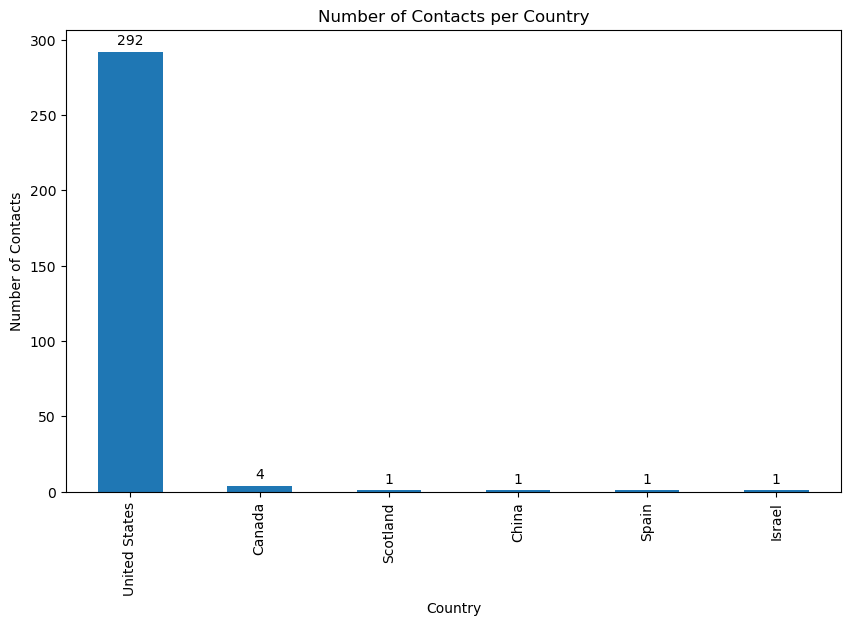

In [17]:
# Bar chart for country distribution with labels
display_graph(country_distribution, 'Number of Contacts per Country', 'Country', 'Number of Contacts', 10)

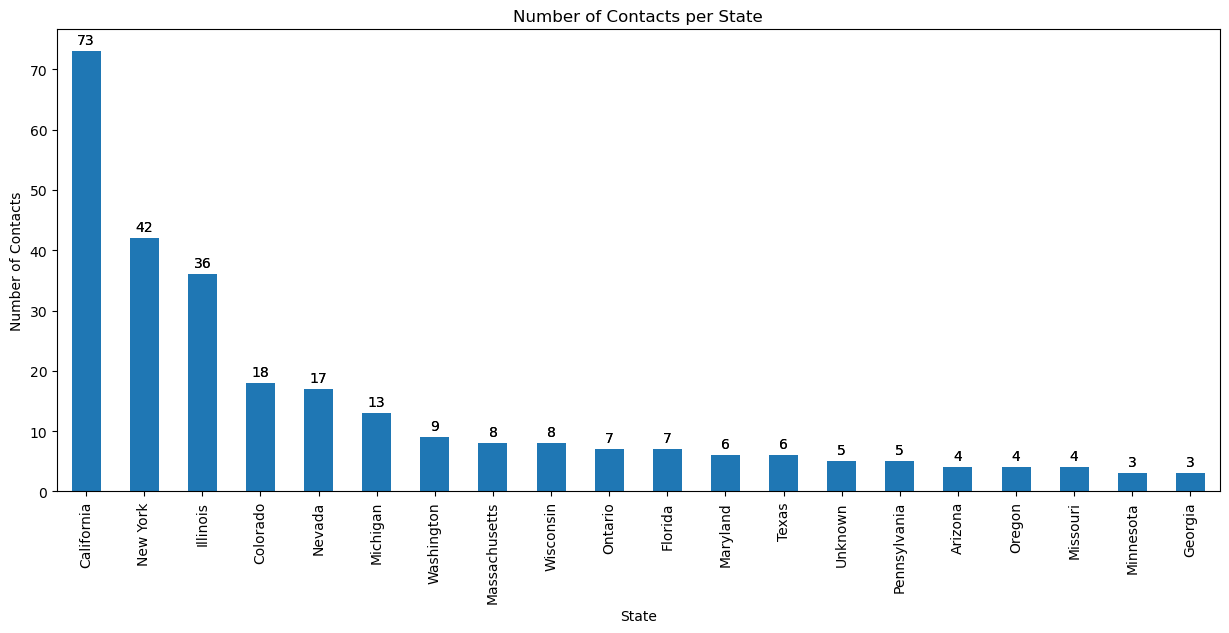

In [18]:
# Bar chart for state distribution with labels
display_graph(state_distribution, 'Number of Contacts per State', 'State', 'Number of Contacts', 15, True)

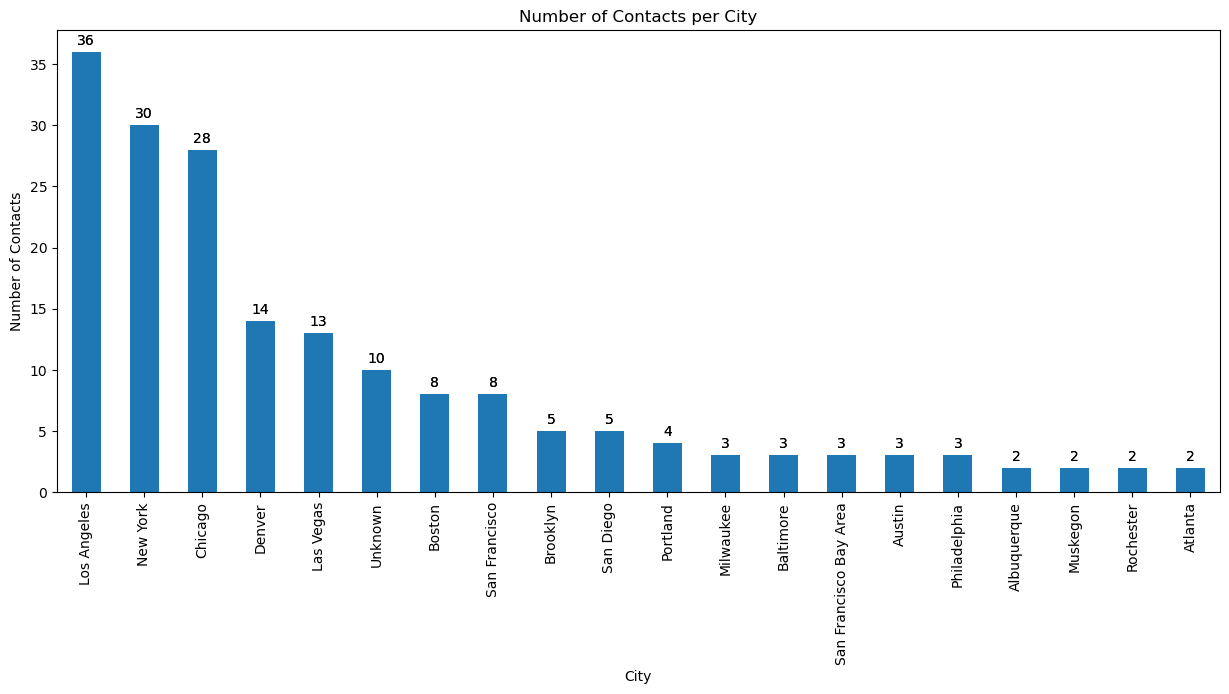

In [19]:
# Bar chart for city distribution with labels
display_graph(city_distribution, 'Number of Contacts per City', 'City', 'Number of Contacts', 15, True)

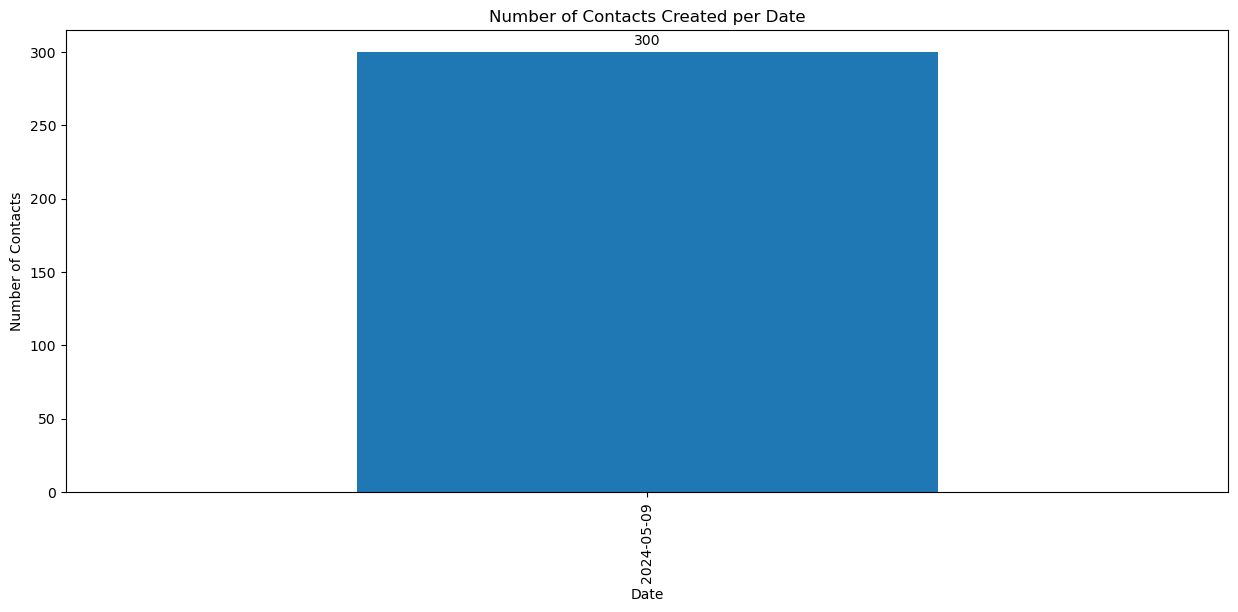

In [20]:
# Histogram for creation dates with labels
display_graph(creation_dates, 'Number of Contacts Created per Date', 'Date', 'Number of Contacts', 15)

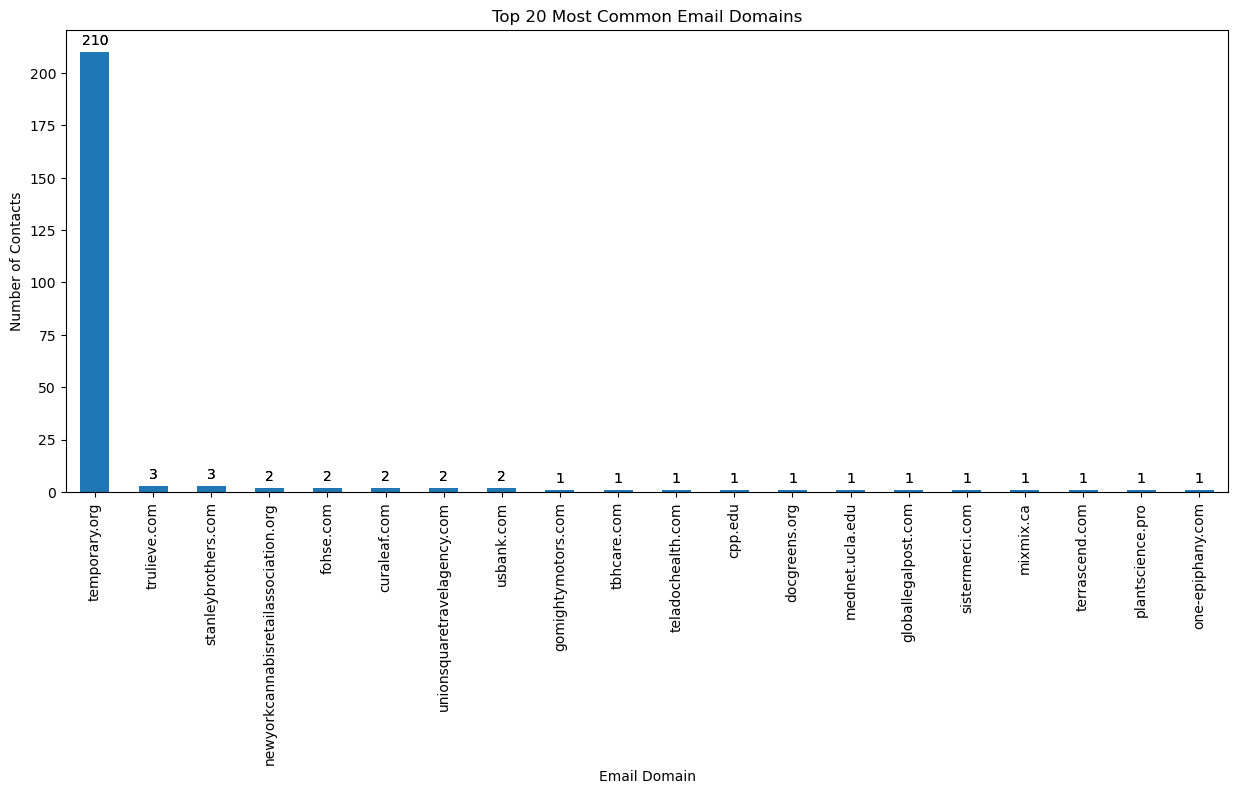

In [21]:
# Extract email domains
contacts_df_cleaned['email_domain'] = contacts_df_cleaned['email'].apply(lambda x: x.split('@')[1])

# Count the occurrences of each domain
domain_counts = contacts_df_cleaned['email_domain'].value_counts()

# Display the top 20 most common email domains
display_graph(domain_counts, 'Top 20 Most Common Email Domains', 'Email Domain', 'Number of Contacts', 15, True)

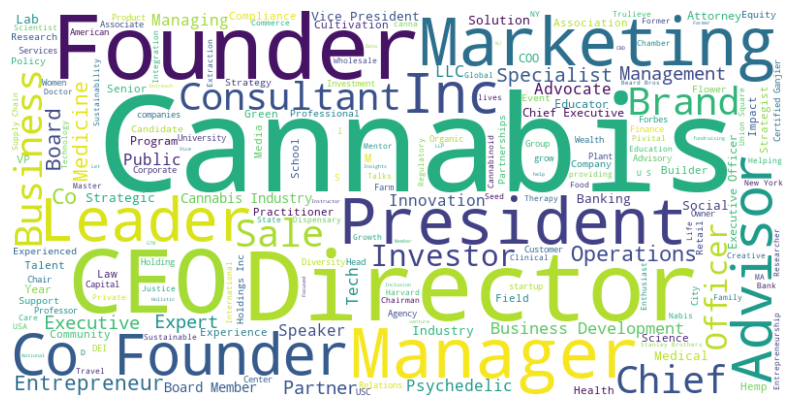

In [22]:
# Combine all descriptions into a single string
all_descriptions = ' '.join(contacts_df_cleaned['description'])

generate_word_cloud(all_descriptions)

# ----------------------------------------------------------------------------------------------------------------

# Contents Dataset

In [23]:
content_df = pd.read_csv(tsv_dict['content'], sep='\t')
content_df.rename(columns={' description': 'description'}, inplace=True)
content_df.head(2)

id                                              title  \
0   1  Justice Department Researcher Questions 0.3% T...   
1   2  Cannabis operator Canopy raising $35 million i...   

                                         description content_type  \
0  The 0.3 percent THC threshold in the federal d...      article   
1  Canadian cannabis company Canopy Growth Corp. ...      article   

   organisation_id                                                url  \
0              NaN  https://www.marijuanamoment.net/justice-depart...   
1              NaN  https://mjbizdaily.com/cannabis-operator-canop...   

   creator_id     created publication_date  
0         1.0  1714286073              NaN  
1         1.0  1714286073              NaN

In [24]:
data_info(content_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                141 non-null    int64  
 1   title             141 non-null    object 
 2   description       141 non-null    object 
 3   content_type      141 non-null    object 
 4   organisation_id   0 non-null      float64
 5   url               141 non-null    object 
 6   creator_id        8 non-null      float64
 7   created           141 non-null    int64  
 8   publication_date  133 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 10.0+ KB
None
-----------------------------------------------------------------------------------------------------------------------------
columns
Index(['id', 'title', 'description', 'content_type', 'organisation_id', 'url',
       'creator_id', 'created', 'publication_date'],
      dtype='object')
------------------

In [25]:
# Drop columns with more than 50% missing values
content_df_cleaned = data_clean_up(content_df)
content_df_cleaned.head(2)

id                    0
title                 0
description           0
content_type          0
organisation_id     141
url                   0
creator_id          133
created               0
publication_date      8
dtype: int64

columns with most of the values null
['organisation_id', 'creator_id']


id                                              title  \
0   1  Justice Department Researcher Questions 0.3% T...   
1   2  Cannabis operator Canopy raising $35 million i...   

                                         description content_type  \
0  The 0.3 percent THC threshold in the federal d...      article   
1  Canadian cannabis company Canopy Growth Corp. ...      article   

                                                 url     created  \
0  https://www.marijuanamoment.net/justice-depart...  1714286073   
1  https://mjbizdaily.com/cannabis-operator-canop...  1714286073   

  publication_date  
0              NaN  
1              NaN

In [26]:
numeric_stats, non_numeric_stats = column_stat(content_df_cleaned)

numeric_stats

count          mean            std           min           25%  \
id       141.0  7.196454e+01      40.907109  1.000000e+00  3.700000e+01   
created  141.0  1.715315e+09  253136.054420  1.714286e+09  1.715376e+09   

                  50%           75%           max  
id       7.200000e+01  1.070000e+02  1.420000e+02  
created  1.715376e+09  1.715376e+09  1.715376e+09

In [27]:
non_numeric_stats

count unique  \
title              141    141   
description        141    141   
content_type       141      1   
url                141    141   
publication_date   133     63   

                                                                top freq  
title             Justice Department Researcher Questions 0.3% T...    1  
description       The 0.3 percent THC threshold in the federal d...    1  
content_type                                                article  141  
url               https://www.marijuanamoment.net/justice-depart...    1  
publication_date                                     March 13, 2024    4

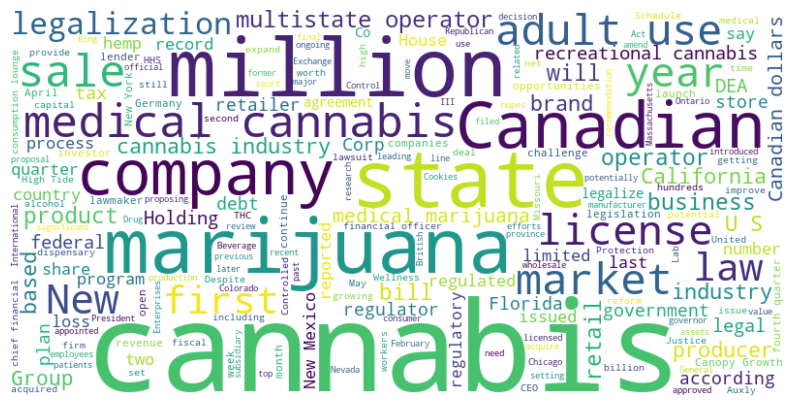

In [28]:
# Combine all descriptions into a single string
all_descriptions = ' '.join(content_df_cleaned['description'])

generate_word_cloud(all_descriptions)

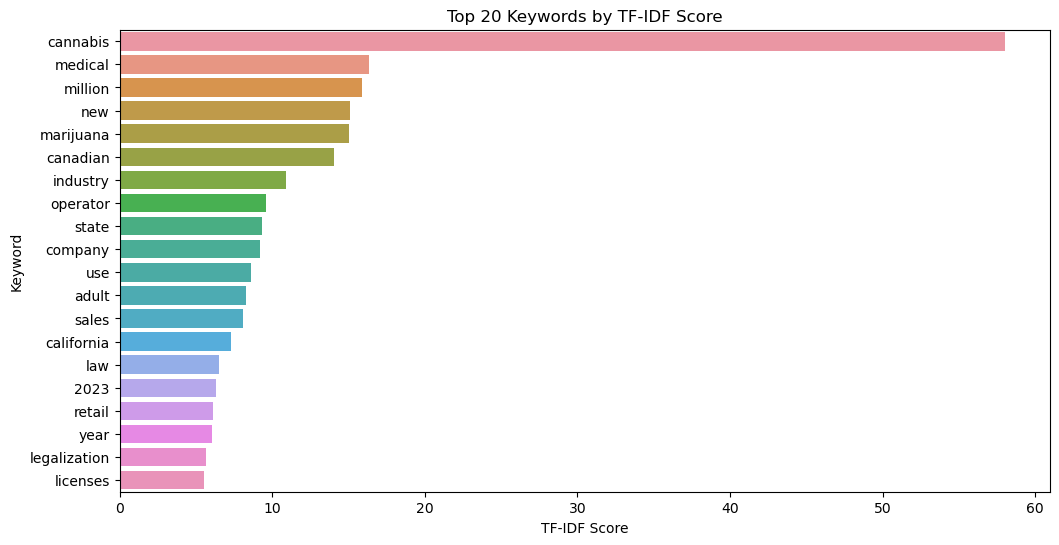

In [29]:
# Combine titles and descriptions into a single text field
content_df_cleaned['text'] = content_df_cleaned['title'] + " " + content_df_cleaned['description']

# Initialize TF-IDF Vectorizer
vectorizer = TfidfVectorizer(stop_words='english', max_features=20)
tfidf_matrix = vectorizer.fit_transform(content_df_cleaned['text'])

# Get feature names and their respective TF-IDF scores
feature_names = vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.toarray().sum(axis=0)

# Create a DataFrame for TF-IDF scores
tfidf_df = pd.DataFrame({'feature': feature_names, 'tfidf_score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='tfidf_score', ascending=False)

# Plot TF-IDF scores
plt.figure(figsize=(12, 6))
sns.barplot(x=tfidf_df['tfidf_score'], y=tfidf_df['feature'])
plt.title('Top 20 Keywords by TF-IDF Score')
plt.xlabel('TF-IDF Score')
plt.ylabel('Keyword')
plt.show()

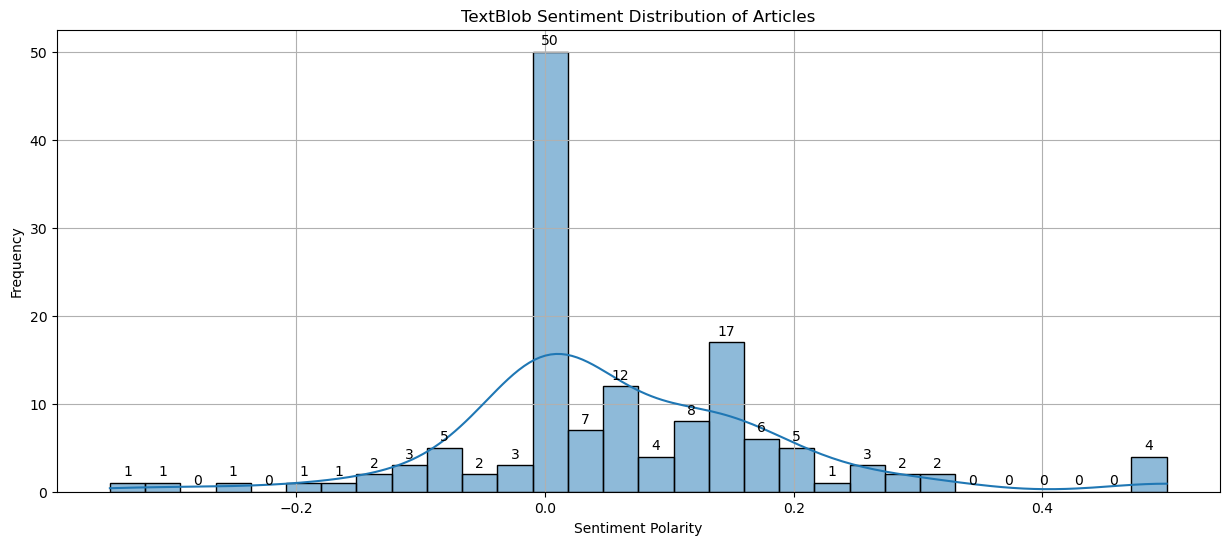

In [30]:
# Function to calculate sentiment using TextBlob
def get_advanced_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Apply TextBlob sentiment analysis on descriptions
content_df_cleaned['advanced_sentiment'] = content_df_cleaned['description'].apply(get_advanced_sentiment)

# Summary statistics of TextBlob sentiment
advanced_sentiment = content_df_cleaned['advanced_sentiment']

# Plot TextBlob sentiment distribution with counts
plot_sentiment_distribution(advanced_sentiment, 'TextBlob Sentiment Distribution of Articles', 'Sentiment Polarity', 'Frequency')

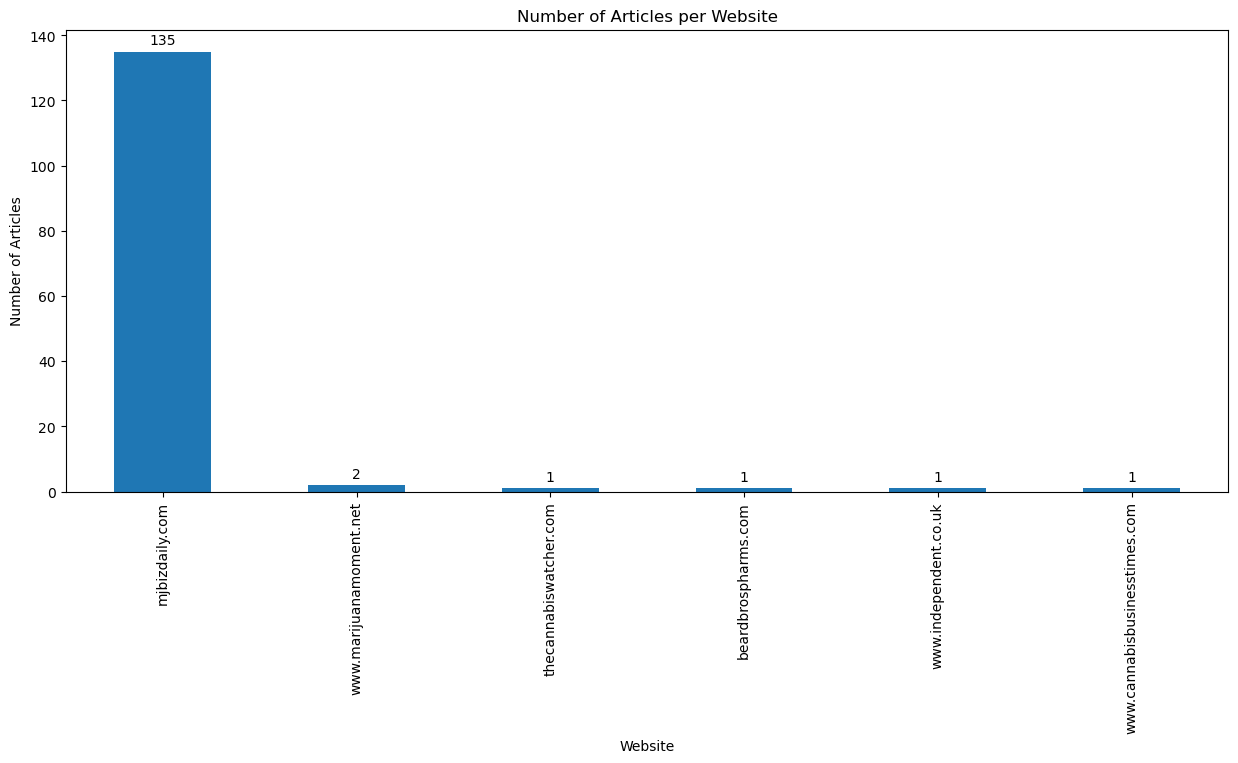

In [31]:
domain_count = content_df_cleaned['url'].apply(lambda x: urlparse(x).netloc).value_counts()

# Plot the distribution of articles per website
display_graph(domain_count, 'Number of Articles per Website', 'Website', 'Number of Articles', 15)

# ----------------------------------------------------------------------------------------------------------------

# Events

In [32]:
events_df = pd.read_csv(tsv_dict['events'], sep='\t')
events_df.head(2)

id                                  title   event_type  \
0   1      2024 Cannabis Research Conference  conferences   
1   2  2024 HBS Cannabis Business Conference  conferences   

                                         description       start         end  \
0  The 8th annual Cannabis Research Conference (C...  1723017600  1723219200   
1  Join us for a scholarly discussion of the cann...  1713639600  1713715200   

           location                                                url  \
0  Fort Collins, CO  https://www.eventbrite.com/e/2024-cannabis-res...   
1        Boston, MA  https://www.eventbrite.com.au/e/2024-hbs-canna...   

         price  organisation_id       created  last_modified         lon  \
0          NaN              NaN  1.711441e+09   1.714920e+09 -105.077011   
1  From $25.00              NaN  1.711441e+09   1.714920e+09  -71.060511   

         lat  
0  40.587178  
1  42.355433

In [33]:
data_info(events_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               266 non-null    int64  
 1   title            266 non-null    object 
 2   event_type       266 non-null    object 
 3   description      262 non-null    object 
 4   start            259 non-null    object 
 5   end              259 non-null    object 
 6   location         266 non-null    object 
 7   url              265 non-null    object 
 8   price            183 non-null    object 
 9   organisation_id  1 non-null      float64
 10  created          266 non-null    float64
 11  last_modified    187 non-null    float64
 12  lon              185 non-null    float64
 13  lat              185 non-null    float64
dtypes: float64(5), int64(1), object(8)
memory usage: 29.2+ KB
None
--------------------------------------------------------------------------------------

In [34]:
# Drop columns with more than 50% missing values
events_df_cleaned = data_clean_up(events_df)

id                   0
title                0
event_type           0
description          4
start                7
end                  7
location             0
url                  1
price               83
organisation_id    265
created              0
last_modified       79
lon                 81
lat                 81
dtype: int64

columns with most of the values null
['organisation_id']


In [35]:
# For 'description', 'start', 'end', 'url', 'price', 'last_modified', 'lon', 'lat' we will fill missing values accordingly
events_df_cleaned = events_df_cleaned.fillna({
    'title': 'No Title',
    'event_type': 'Unknown',
    'description': 'No Description',
    'start': 0,
    'end': 0,
    'location': 'No Location',
    'url': 'No URL',
    'price': 'Not Available',
    'organisation_id': 0,
    'created': 0,
    'last_modified': 0,
    'lon': 0.0,
    'lat': 0.0
})
events_df_cleaned['price'] = events_df_cleaned['price'].str.capitalize()

In [36]:
events_df_cleaned.head(2)

id                                  title   event_type  \
0   1      2024 Cannabis Research Conference  conferences   
1   2  2024 HBS Cannabis Business Conference  conferences   

                                         description       start         end  \
0  The 8th annual Cannabis Research Conference (C...  1723017600  1723219200   
1  Join us for a scholarly discussion of the cann...  1713639600  1713715200   

           location                                                url  \
0  Fort Collins, CO  https://www.eventbrite.com/e/2024-cannabis-res...   
1        Boston, MA  https://www.eventbrite.com.au/e/2024-hbs-canna...   

           price       created  last_modified         lon        lat  
0  Not available  1.711441e+09   1.714920e+09 -105.077011  40.587178  
1    From $25.00  1.711441e+09   1.714920e+09  -71.060511  42.355433

In [37]:
numeric_stats, non_numeric_stats = column_stat(events_df_cleaned)

numeric_stats

count          mean           std         min           25%  \
id             266.0  7.530000e+02  4.421557e+02    1.000000  3.815000e+02   
created        266.0  1.707178e+09  1.050824e+08  -74.451817  1.711441e+09   
last_modified  266.0  1.199157e+09  7.879209e+08    0.000000  0.000000e+00   
lon            266.0 -6.263753e+01  4.367620e+01 -124.015952 -9.019102e+01   
lat            266.0  2.578637e+01  1.761462e+01    0.000000  0.000000e+00   

                        50%           75%           max  
id             8.435000e+02  1.189750e+03  1.256000e+03  
created        1.714066e+09  1.715368e+09  1.715368e+09  
last_modified  1.714921e+09  1.714923e+09  1.714937e+09  
lon           -7.703654e+01  0.000000e+00  0.000000e+00  
lat            3.401947e+01  3.976106e+01  4.497730e+01

In [38]:
non_numeric_stats

count unique                                                top  \
title         266    235           Sound Healing with The Singing Bowl Lady   
event_type    266      7                                            webinar   
description   266    230  Join us in this powerful immersion into the to...   
start         266    153                                                  0   
end           266    158                                                  0   
location      266    106                                             online   
url           266    266  https://www.eventbrite.com/e/2024-cannabis-res...   
price         266     19                                               Free   

            freq  
title          8  
event_type    79  
description    8  
start         79  
end           79  
location      79  
url            1  
price        144

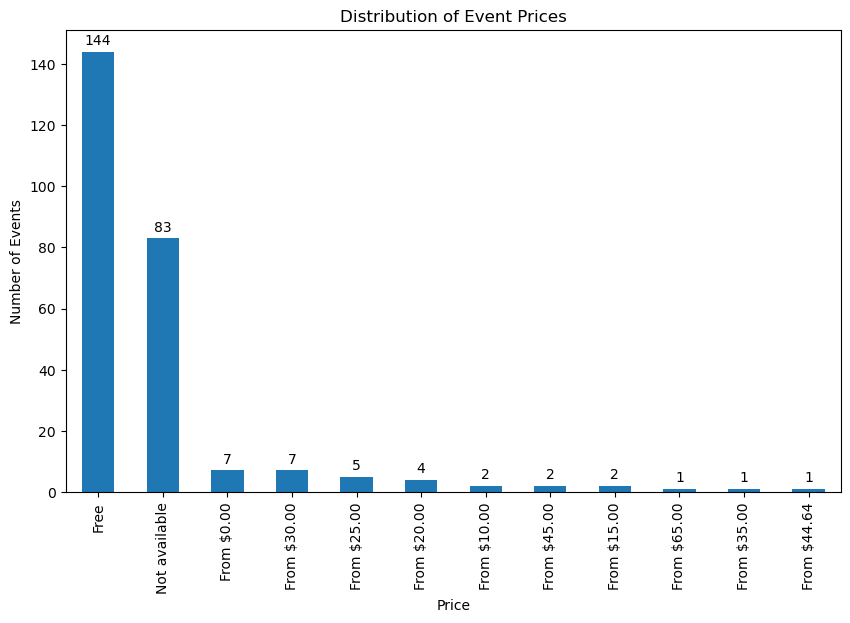

In [39]:
price_counts_capitalized = events_df_cleaned['price'].value_counts()

display_graph(price_counts_capitalized.head(12), 'Distribution of Event Prices', 'Price', 'Number of Events', 10)

C:\Users\dhyan\AppData\Local\Temp\ipykernel_23580\167072827.py:6: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  events_df_cleaned['start'] = pd.to_datetime(events_df_cleaned['start'], unit='s')
C:\Users\dhyan\AppData\Local\Temp\ipykernel_23580\167072827.py:7: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  events_df_cleaned['end'] = pd.to_datetime(events_df_cleaned['end'], unit='s')


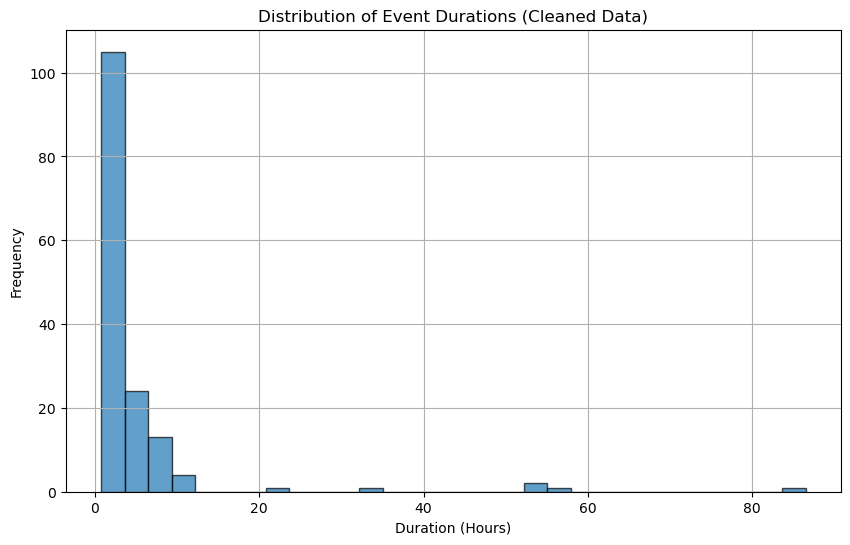

In [40]:
# Delete rows where 'start' and 'end' columns contain non-numeric values
events_df_cleaned = events_df_cleaned[pd.to_numeric(events_df_cleaned['start'], errors='coerce').notnull()]
events_df_cleaned = events_df_cleaned[pd.to_numeric(events_df_cleaned['end'], errors='coerce').notnull()]

# Convert 'start' and 'end' columns to datetime again
events_df_cleaned['start'] = pd.to_datetime(events_df_cleaned['start'], unit='s')
events_df_cleaned['end'] = pd.to_datetime(events_df_cleaned['end'], unit='s')

# Recalculate event duration in hours
events_df_cleaned['duration'] = (events_df_cleaned['end'] - events_df_cleaned['start']).dt.total_seconds() / 3600

events_duration = events_df_cleaned[events_df_cleaned['duration'] > 0]

plt.figure(figsize=(10, 6))
plt.hist(events_duration['duration'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Event Durations (Cleaned Data)')
plt.xlabel('Duration (Hours)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

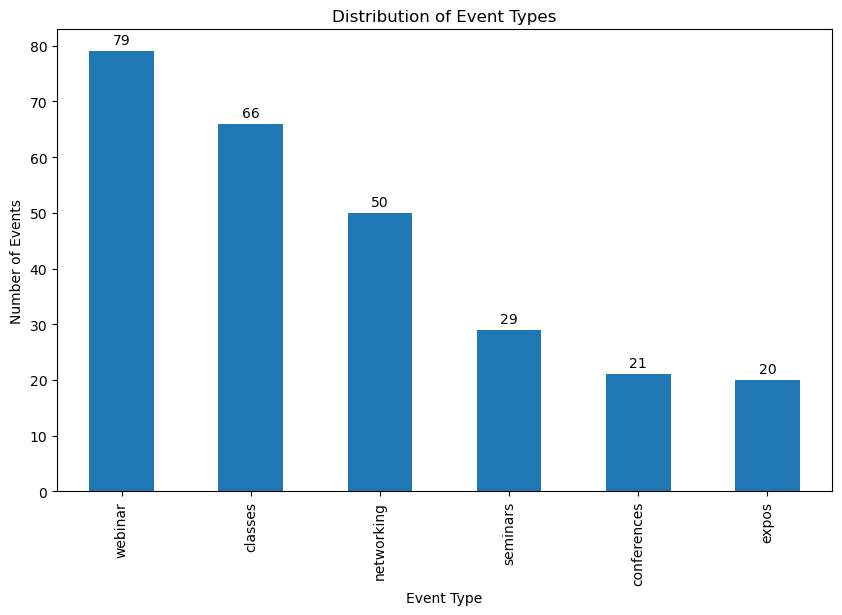

In [41]:
event_type_counts = events_df_cleaned['event_type'].value_counts()

display_graph(event_type_counts, 'Distribution of Event Types', 'Event Type', 'Number of Events', 10)

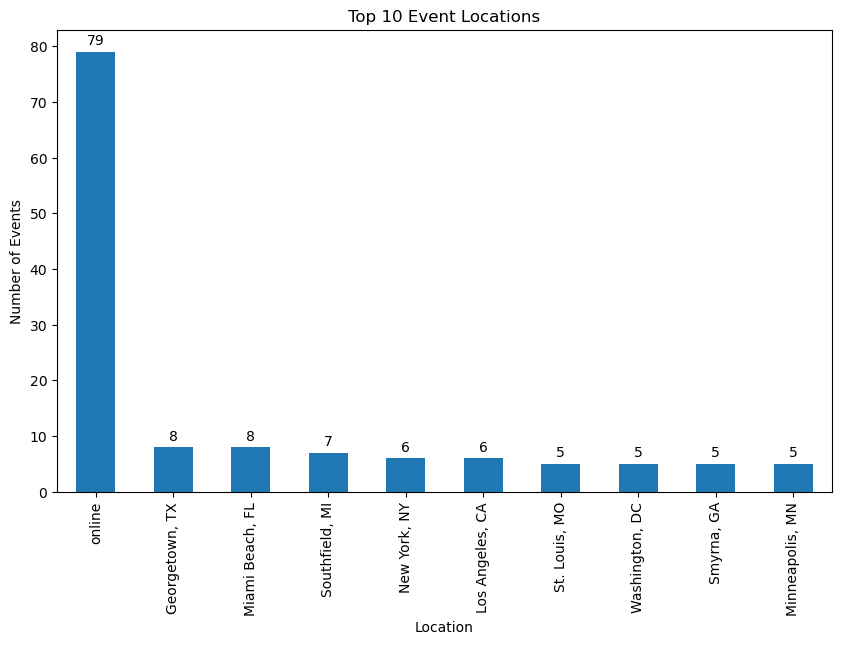

In [42]:
location_counts = events_df_cleaned['location'].value_counts().head(10)

display_graph(location_counts, 'Top 10 Event Locations', 'Location', 'Number of Events', 10)

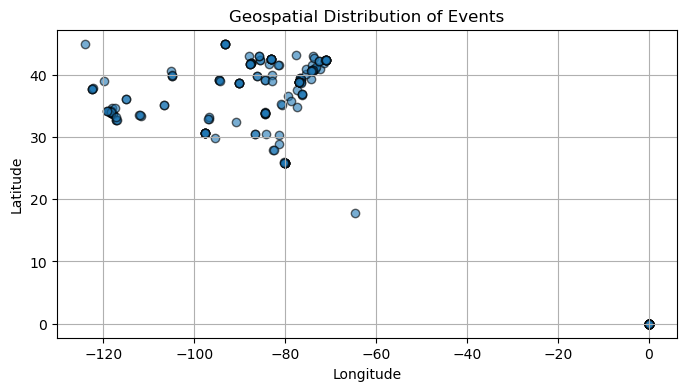

In [43]:
# Plotting the geospatial distribution of events based on latitude and longitude
plt.figure(figsize=(8, 4))
plt.scatter(events_df_cleaned['lon'], events_df_cleaned['lat'], alpha=0.6, edgecolor='k')
plt.title('Geospatial Distribution of Events')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [44]:
import folium
from folium.plugins import MarkerCluster

# Create a base map
map_center = [events_df_cleaned['lat'].mean(), events_df_cleaned['lon'].mean()]
event_map = folium.Map(location=map_center, zoom_start=5)

# Add marker cluster to the map
marker_cluster = MarkerCluster().add_to(event_map)

# Add points to the marker cluster
for idx, row in events_df_cleaned.iterrows():
    folium.Marker(location=[row['lat'], row['lon']], 
                  popup=f"{row['title']}<br>{row['location']}").add_to(marker_cluster)

# Save the map to an HTML file
map_path = '../Dataset/event_map.html'
event_map.save(map_path)

map_path

'../Dataset/event_map.html'

# ----------------------------------------------------------------------------------------------------------------

# Organisations

In [45]:
organisations_df = pd.read_csv(tsv_dict['organisations'], sep='\t')
organisations_df.head(2)

id             name           city state        country    industry  \
0   1             NACB  San Francisco    CA  United States  Networking   
1  18  Element Apothec    Los Angeles    CA  United States      Retail   

                                             profile     created  \
0  {"needs": [ "Health Benefits",  "Supply Chain ...  1710004784   
1  {"needs": ["Community Activation", "Community ...  1714143150   

                                   description  linkedin_url  phone_number  \
0  National Association of Cannabis Businesses           NaN           NaN   
1     Retail Health and Personal Care Products           NaN           NaN   

   email  year_founded                    logo_name  
0    NaN           NaN  nacb_royal_blue_option2.png  
1    NaN           NaN          element_apothec.png

In [46]:
data_info(organisations_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            19 non-null     int64  
 1   name          19 non-null     object 
 2   city          16 non-null     object 
 3   state         19 non-null     object 
 4   country       19 non-null     object 
 5   industry      19 non-null     object 
 6   profile       19 non-null     object 
 7   created       19 non-null     int64  
 8   description   19 non-null     object 
 9   linkedin_url  0 non-null      float64
 10  phone_number  0 non-null      float64
 11  email         0 non-null      float64
 12  year_founded  0 non-null      float64
 13  logo_name     19 non-null     object 
dtypes: float64(4), int64(2), object(8)
memory usage: 2.2+ KB
None
-----------------------------------------------------------------------------------------------------------------------------
columns
Ind

In [47]:
# Drop columns with more than 50% missing values
organisations_df_cleaned = data_clean_up(organisations_df)

id               0
name             0
city             3
state            0
country          0
industry         0
profile          0
created          0
description      0
linkedin_url    19
phone_number    19
email           19
year_founded    19
logo_name        0
dtype: int64

columns with most of the values null
['linkedin_url', 'phone_number', 'email', 'year_founded']


In [48]:
# Fill missing values in 'city' with 'Unknown'
organisations_df_cleaned['city'].fillna('Unknown', inplace=True)

In [49]:
organisations_df_cleaned.head(2)

id             name           city state        country    industry  \
0   1             NACB  San Francisco    CA  United States  Networking   
1  18  Element Apothec    Los Angeles    CA  United States      Retail   

                                             profile     created  \
0  {"needs": [ "Health Benefits",  "Supply Chain ...  1710004784   
1  {"needs": ["Community Activation", "Community ...  1714143150   

                                   description                    logo_name  
0  National Association of Cannabis Businesses  nacb_royal_blue_option2.png  
1     Retail Health and Personal Care Products          element_apothec.png

In [50]:
numeric_stats, non_numeric_stats = column_stat(organisations_df_cleaned)

numeric_stats

count          mean            std           min           25%  \
id        19.0  2.542105e+01       8.105662  1.000000e+00  2.150000e+01   
created   19.0  1.713925e+09  949406.272915  1.710005e+09  1.714143e+09   

                  50%           75%           max  
id       2.600000e+01  3.100000e+01  3.600000e+01  
created  1.714143e+09  1.714143e+09  1.714143e+09

In [51]:
non_numeric_stats

count unique                                                top  \
name           19     19                                               NACB   
city           19     12                                        Los Angeles   
state          19      5                                                 CA   
country        19      1                                      United States   
industry       19     14                                         Networking   
profile        19     19  {"needs": [ "Health Benefits",  "Supply Chain ...   
description    19     19        National Association of Cannabis Businesses   
logo_name      19     19                        nacb_royal_blue_option2.png   

            freq  
name           1  
city           5  
state         13  
country       19  
industry       2  
profile        1  
description    1  
logo_name      1

In [52]:
import json

# Extract needs from the profile column
organisations_df_cleaned['needs'] = organisations_df_cleaned['profile'].apply(lambda x: json.loads(x).get('needs', []))

# Flatten the list of needs and calculate the frequency of each need
all_needs = organisations_df_cleaned['needs'].explode().value_counts()
all_needs

needs
Business Support                                            12
Industry Analysis Service                                   11
User Acquisition                                            11
Audience Analysis Service                                   11
Market Expansion Strategy                                   11
                                                            ..
Customer Service and Retention Strategy Service              1
Communication of Policy Positions                            1
 Bussines support solutions                                  1
Communication Strategy through/ Leadership NACB Solution     1
Operational Efficiency Measures                              1
Name: count, Length: 138, dtype: int64

In [53]:
# Analyze the distribution of organisations by country
country_distribution = get_distribution(organisations_df_cleaned, 'country')

# Analyze the distribution of organisations by state
state_distribution = get_distribution(organisations_df_cleaned, 'state')

# Analyze the distribution of organisations by city
city_distribution = get_distribution(organisations_df_cleaned, 'city')

# Analyze the distribution of organisations by industry
industry_distribution = get_distribution(organisations_df_cleaned, 'industry')

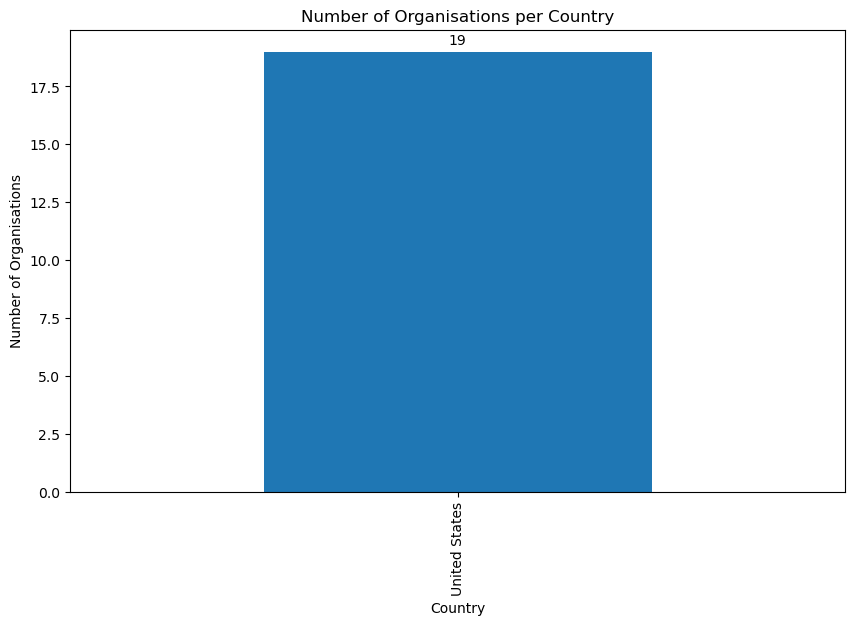

In [54]:
# Bar chart for country distribution with labels
display_graph(country_distribution, 'Number of Organisations per Country', 'Country', 'Number of Organisations', 10)

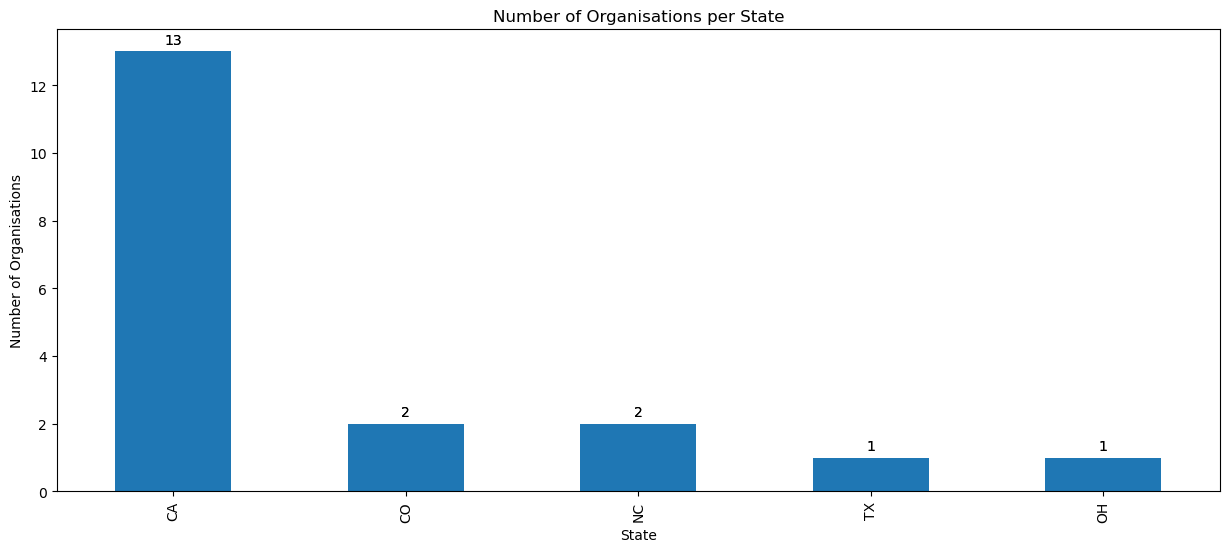

In [55]:
# Bar chart for state distribution with labels
display_graph(state_distribution, 'Number of Organisations per State', 'State', 'Number of Organisations', 15, True)

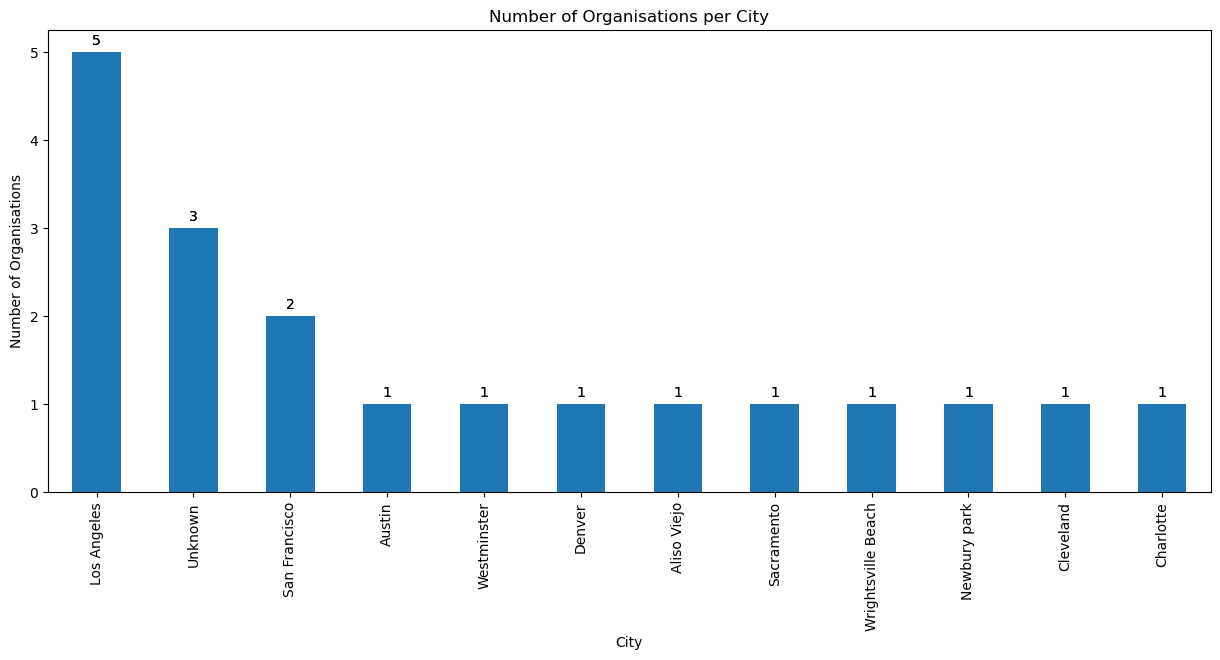

In [56]:
# Bar chart for city distribution with labels
display_graph(city_distribution, 'Number of Organisations per City', 'City', 'Number of Organisations', 15, True)

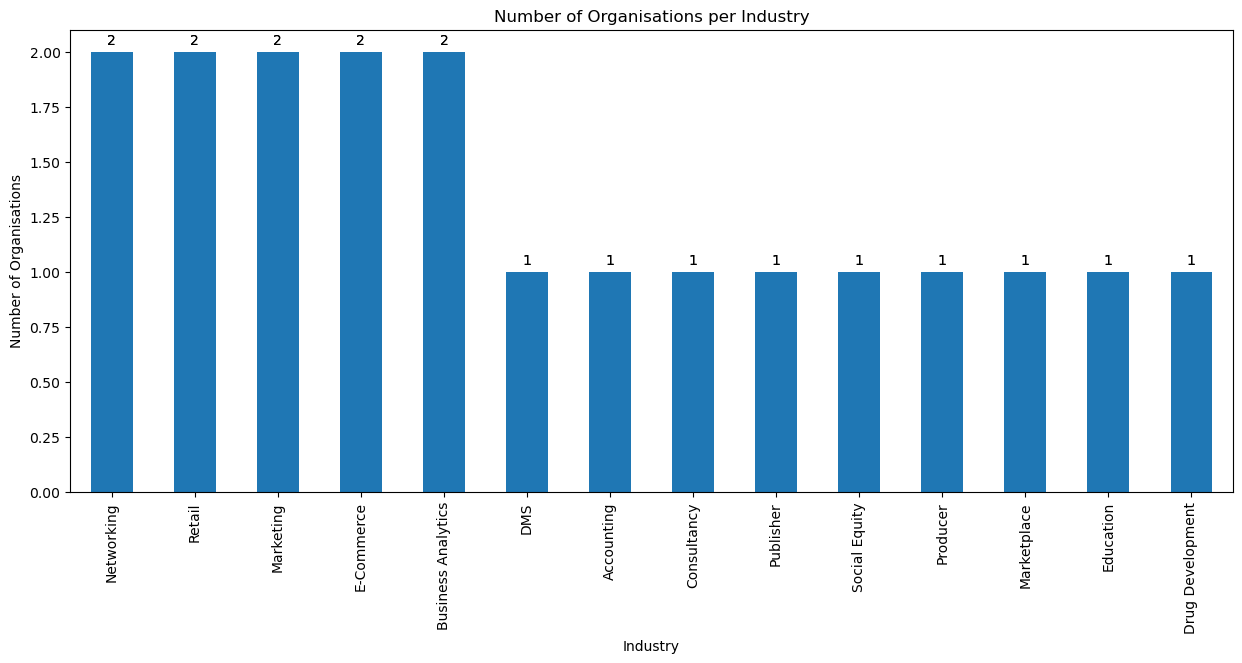

In [57]:
# Bar chart for industry distribution with labels
display_graph(industry_distribution, 'Number of Organisations per Industry', 'Industry', 'Number of Organisations', 15, True)

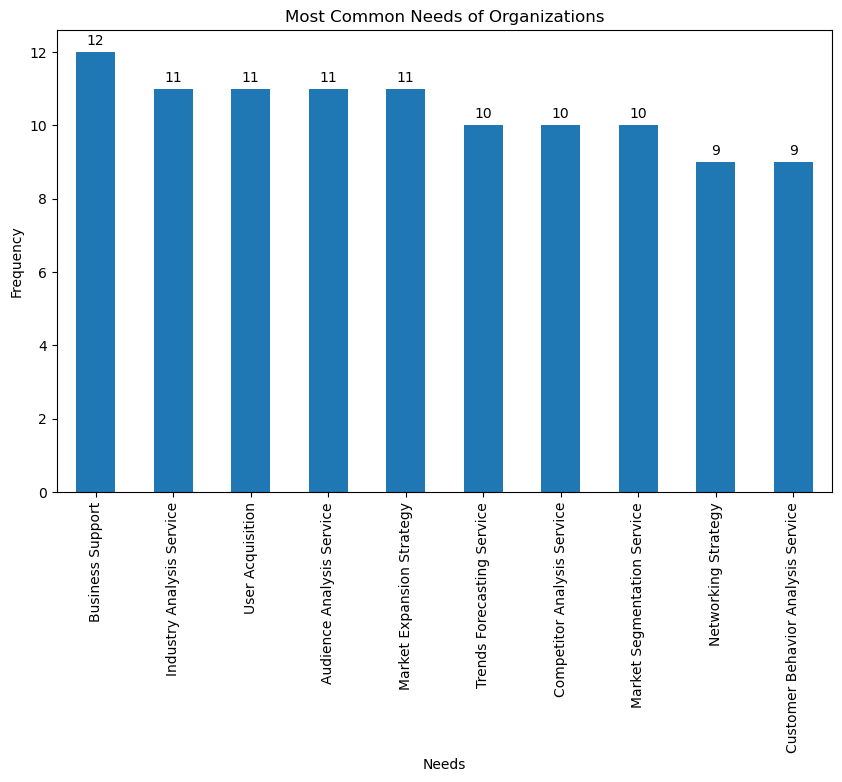

In [58]:
# Bar chart for industry distribution with labels
display_graph(all_needs.head(10), 'Most Common Needs of Organizations', 'Needs', 'Frequency', 10)

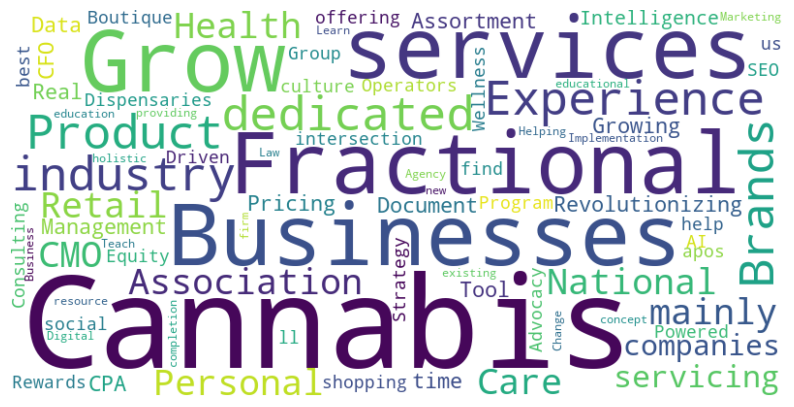

In [59]:
# Combine all descriptions into a single string
all_descriptions = ' '.join(organisations_df_cleaned['description'])

generate_word_cloud(all_descriptions)

# ----------------------------------------------------------------------------------------------------------------

# Recommendations

In [60]:
recommendations_df = pd.read_csv(tsv_dict['recommendations'], sep='\t')
recommendations_df.head(2)

id                                              title asset_type  asset_id  \
0   1  AFC Gamma is looking to finance unburdened can...    content        95   
1   2  Massachusetts cannabis regulator expanding sec...    content        71   

   organisation_id  user_id  creator_id  system_score  user_score     created  \
0                1       98         143          0.31         NaN  1715376481   
1                1       98          98          0.30         NaN  1715376481   

         opened       deleted         saved   clicked_out  
0  1.715384e+09  1.715391e+09           NaN  1.715387e+09  
1  1.715384e+09           NaN  1.715387e+09           NaN

In [61]:
data_info(recommendations_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658 entries, 0 to 657
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               658 non-null    int64  
 1   title            658 non-null    object 
 2   asset_type       658 non-null    object 
 3   asset_id         658 non-null    int64  
 4   organisation_id  658 non-null    int64  
 5   user_id          658 non-null    int64  
 6   creator_id       658 non-null    int64  
 7   system_score     658 non-null    float64
 8   user_score       0 non-null      float64
 9   created          658 non-null    int64  
 10  opened           625 non-null    float64
 11  deleted          403 non-null    float64
 12  saved            338 non-null    float64
 13  clicked_out      414 non-null    float64
dtypes: float64(6), int64(6), object(2)
memory usage: 72.1+ KB
None
--------------------------------------------------------------------------------------

In [62]:
# Drop columns with more than 50% missing values
recommendations_df_cleaned = data_clean_up(recommendations_df)

id                   0
title                0
asset_type           0
asset_id             0
organisation_id      0
user_id              0
creator_id           0
system_score         0
user_score         658
created              0
opened              33
deleted            255
saved              320
clicked_out        244
dtype: int64

columns with most of the values null
['user_score']


In [63]:
numeric_stats, non_numeric_stats = column_stat(recommendations_df_cleaned)

numeric_stats

count          mean          std           min           25%  \
id               658.0  3.295000e+02   190.092521  1.000000e+00  1.652500e+02   
asset_id         658.0  4.665350e+02   439.899223  2.000000e+00  9.600000e+01   
organisation_id  658.0  2.417173e+01     8.907917  1.000000e+00  2.100000e+01   
user_id          658.0  1.195061e+02    14.142915  9.600000e+01  1.072500e+02   
creator_id       658.0  1.216520e+02    22.522348  9.800000e+01  9.800000e+01   
system_score     658.0  4.117933e-01     0.101418  2.500000e-01  3.100000e-01   
created          658.0  1.715377e+09    73.957030  1.715376e+09  1.715377e+09   
opened           625.0  1.715383e+09  1613.158723  1.715380e+09  1.715380e+09   
deleted          403.0  1.715386e+09  4629.693355  1.715380e+09  1.715384e+09   
saved            338.0  1.715383e+09  3430.181954  1.715380e+09  1.715380e+09   
clicked_out      414.0  1.715386e+09  3777.557679  1.715380e+09  1.715380e+09   

                          50%           75%           max  
id               3.295000e+02  4.937500e+02  6.580000e+02  
asset_id         3.860000e+02  5.855000e+02  1.256000e+03  
organisation_id  2.500000e+01  3.000000e+01  3.600000e+01  
user_id          1.180000e+02  1.330000e+02  1.440000e+02  
creator_id       1.430000e+02  1.430000e+02  1.440000e+02  
system_score     4.000000e-01  4.900000e-01  6.400000e-01  
created          1.715377e+09  1.715377e+09  1.715377e+09  
opened           1.715384e+09  1.715384e+09  1.715384e+09  
deleted          1.715384e+09  1.715391e+09  1.715395e+09  
saved            1.715381e+09  1.715387e+09  1.715388e+09  
clicked_out      1.715387e+09  1.715387e+09  1.715391e+09

In [64]:
non_numeric_stats

count unique                                                top  \
title        658     75  Gabrielle Feldman | Program Manager for the En...   
asset_type   658      3                                            contact   

           freq  
title        40  
asset_type  220

In [65]:
recommendations_df_cleaned.head(2)

id                                              title asset_type  asset_id  \
0   1  AFC Gamma is looking to finance unburdened can...    content        95   
1   2  Massachusetts cannabis regulator expanding sec...    content        71   

   organisation_id  user_id  creator_id  system_score     created  \
0                1       98         143          0.31  1715376481   
1                1       98          98          0.30  1715376481   

         opened       deleted         saved   clicked_out  
0  1.715384e+09  1.715391e+09           NaN  1.715387e+09  
1  1.715384e+09           NaN  1.715387e+09           NaN

In [66]:
# Perform analysis
# Example analysis: Count of recommendations by asset_type
recommendation_counts = recommendations_df_cleaned['asset_type'].value_counts()
print("Recommendation Counts by Asset Type")
print(recommendation_counts)

Recommendation Counts by Asset Type
asset_type
contact    220
event      220
content    218
Name: count, dtype: int64


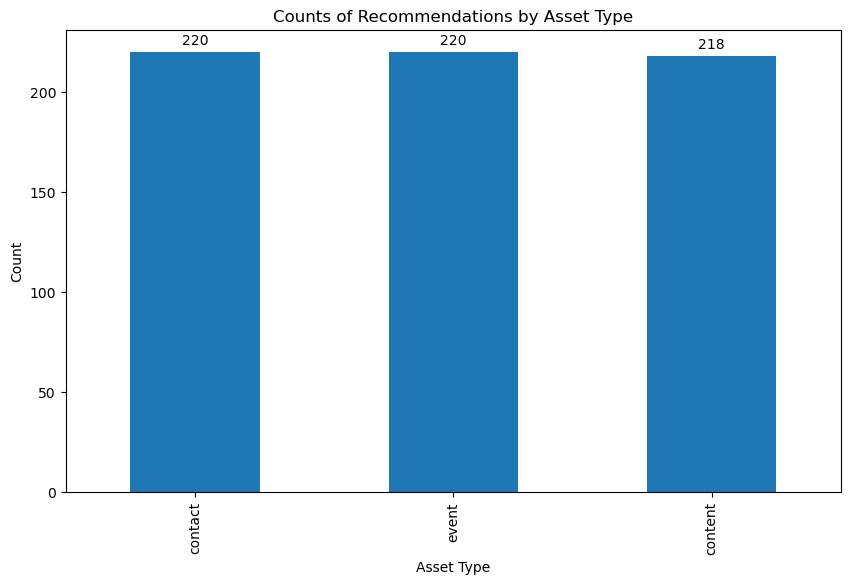

In [67]:
# Create a bar plot for counts of recommendations by asset_type
display_graph(recommendation_counts, 'Counts of Recommendations by Asset Type', 'Asset Type', 'Count', 10)

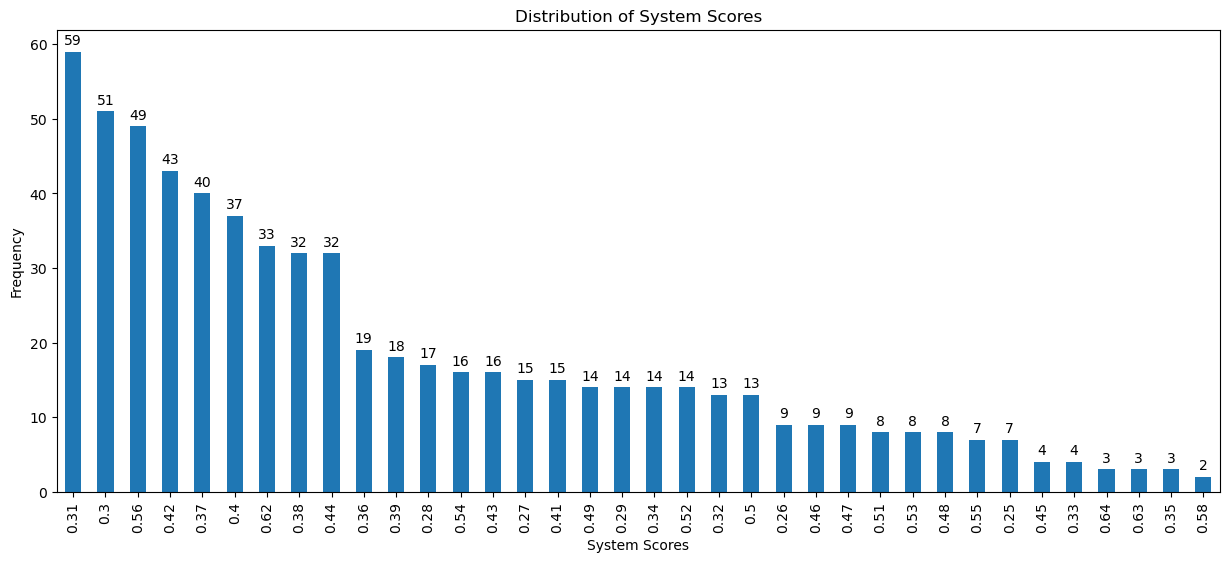

In [68]:
top_15_system_scores = recommendations_df_cleaned['system_score'].value_counts()
display_graph(top_15_system_scores, 'Distribution of System Scores', 'System Scores', 'Frequency', 15)

In [69]:
# Function to merge recommendations with appropriate dataset
def merge_recommendations(recommendations, contacts, content, events):
    # Separate recommendations by asset_type
    contact_recommendations = recommendations[recommendations['asset_type'] == 'contact']
    content_recommendations = recommendations[recommendations['asset_type'] == 'content']
    event_recommendations = recommendations[recommendations['asset_type'] == 'event']
    
    # Merge with appropriate dataset
    merged_contacts = pd.merge(contact_recommendations, contacts, left_on='asset_id', right_on='id', how='left')
    merged_content = pd.merge(content_recommendations, content, left_on='asset_id', right_on='id', how='left')
    merged_events = pd.merge(event_recommendations, events, left_on='asset_id', right_on='id', how='left')
    
    return [merged_contacts, merged_content, merged_events]
    
# Merge recommendations with appropriate datasets
merged_contacts, merged_content, merged_events = merge_recommendations(recommendations_df_cleaned, contacts_df_cleaned, content_df_cleaned, events_df_cleaned)

# Display the first few rows of the merged dataframe
merged_contacts.head(2)

id_x                                              title asset_type  \
0     6  David Gonzales | Founder of “A Cannabis Compan...    contact   
1     7  Emanuel Zareh | Investor, Professor. Focused o...    contact   

   asset_id  organisation_id  user_id  creator_id  system_score   created_x  \
0       290                1       98          98          0.51  1715376481   
1       150                1       98         143          0.47  1715376481   

         opened  ...  last_name                         email  role_id  \
0  1.715380e+09  ...   Gonzales  David_Gonzales@temporary.org        0   
1  1.715384e+09  ...      Zareh       emanuel.zareh@emles.com        0   

             city        country       state           created_y  \
0  West Hollywood  United States  California 2024-05-09 14:35:41   
1        New York  United States    New York 2024-05-09 14:35:41   

                                  linkedin_url  \
0  https://www.linkedin.com/in/davidagonzales/   
1          https://www.linkedin.com/in/ezareh/   

                                         description   email_domain  
0  Founder of “A Cannabis Company” , #ÅCannabis M...  temporary.org  
1  Investor, Professor. Focused on venture capita...      emles.com  

[2 rows x 25 columns]

In [70]:
# Top recommended contacts based on system_score
top_contacts = merged_contacts.nlargest(50, 'system_score').drop_duplicates(subset='asset_id')[['id_x', 'title', 'asset_id', 'system_score']]
top_contacts.head(5)

id_x                                              title  asset_id  \
170   516                        Christine Parman | Cannabis       220   
171   517  Gabrielle Feldman | Program Manager for the En...       386   
125   381  Ziva Cooper | Director of the UCLA Center for ...       291   
21     67  Laura Farren | Academic Research Partnerships ...       402   
22     68                  Erin Alexander | Content @ TechGC       416   

     system_score  
170          0.64  
171          0.63  
125          0.62  
21           0.58  
22           0.56

In [71]:
merged_content.head(2)

id_x                                            title_x asset_type  \
0     1  AFC Gamma is looking to finance unburdened can...    content   
1     2  Massachusetts cannabis regulator expanding sec...    content   

   asset_id  organisation_id  user_id  creator_id  system_score   created_x  \
0        95                1       98         143          0.31  1715376481   
1        71                1       98          98          0.30  1715376481   

         opened  ...   clicked_out  id_y  \
0  1.715384e+09  ...  1.715387e+09    95   
1  1.715384e+09  ...           NaN    71   

                                             title_y  \
0  AFC Gamma is looking to finance unburdened can...   
1  Massachusetts cannabis regulator expanding sec...   

                                         description content_type  \
0  Publicly traded cannabis industry lender AFC G...      article   
1  Massachusetts Cannabis Control Commission (CCC...      article   

                                                 url   created_y  \
0  https://mjbizdaily.com/afc-gamma-looks-to-unbu...  1715376400   
1  https://mjbizdaily.com/massachusetts-expanding...  1715376400   

  publication_date                                               text  \
0    March 8, 2024  AFC Gamma is looking to finance unburdened can...   
1   March 26, 2024  Massachusetts cannabis regulator expanding sec...   

  advanced_sentiment  
0          -0.009259  
1          -0.250000  

[2 rows x 22 columns]

In [72]:
# Top recommended content based on system_score
top_content = merged_content.nlargest(50, 'system_score').drop_duplicates(subset='asset_id')[['id_x', 'title_x', 'asset_id', 'system_score']]
top_content.head(5)

id_x                                            title_x  asset_id  \
155   466  Cannabis operator Canopy raising $35 million i...         2   
20     61  Largest cannabis MSOs lay out modest expansion...       137   
156   467  Institutional investor puts $50 million into c...        14   
158   469  AFC Gamma provides $34 million to Sunburn Cann...        69   
159   470  Chicago Atlantic lends $20 million to Nova Far...        45   

     system_score  
155          0.40  
20           0.38  
156          0.38  
158          0.37  
159          0.36

In [73]:
merged_events.head(2)

id_x                                            title_x asset_type  \
0    11  Supply Chain Challenges and Cannabis: A Global...      event   
1    12  Fund Your Business: Options for Raising Capita...      event   

   asset_id  organisation_id  user_id  creator_id  system_score   created_x  \
0      1208                1       98          99          0.46  1715376481   
1      1246                1       98          98          0.46  1715376481   

         opened  ...      start        end  location  \
0  1.715380e+09  ... 1970-01-01 1970-01-01    online   
1  1.715380e+09  ... 1970-01-01 1970-01-01    online   

                                                 url price     created_y  \
0  https://www.cannabisbusinesstimes.com/media/su...  Free  1.715368e+09   
1  https://www.cannabisbusinesstimes.com/media/fu...  Free  1.715368e+09   

  last_modified  lon  lat duration  
0           0.0  0.0  0.0      0.0  
1           0.0  0.0  0.0      0.0  

[2 rows x 27 columns]

In [74]:
# Top recommended events based on system_score
top_events = merged_events.nlargest(50, 'system_score').drop_duplicates(subset='asset_id')[['id_x', 'title_x', 'asset_id', 'system_score']]
top_events.head(5)

id_x                                            title_x  asset_id  \
65   206  Hiring in the 21st Century. How Your Cannabis ...      1256   
85   266  Agrify: From Flower to Diamonds  How to Use Te...      1194   
0     11  Supply Chain Challenges and Cannabis: A Global...      1208   
1     12  Fund Your Business: Options for Raising Capita...      1246   
86   267  Surna: What to Expect When You're Expanding or...      1245   

    system_score  
65          0.50  
85          0.47  
0           0.46  
1           0.46  
86          0.44

# ----------------------------------------------------------------------------------------------------------------

# Users

In [75]:
users_df = pd.read_csv(tsv_dict['users'], sep='\t')
users_df.head(5)

id  first_name last_name                                email  role_id  \
0    1         Dan    Heesch                     daniel@sight.dev        5   
1   96  Pongsakorn  Chuaynum        pongsakorn.chuaynum@gmail.com        3   
2   98      Daniel    Heesch              daniel.heesch@gmail.com        1   
3   99    Mary-Ann    Rocero                     maryann@rhvco.io        1   
4  100    Alasdair    Finley  alasdair.finley@element_apothec.com        3   

   organisation_id          picture_name         position gender  city  \
0              NaN                   NaN        Tech Lead      m   NaN   
1             18.0                   NaN    Growth Hacker      m   NaN   
2              1.0                   NaN            Admin      m   NaN   
3              1.0                   NaN              COO      f   NaN   
4             18.0  frame_1000001585.png  Account Manager      f   NaN   

   country  state     created  phone_number  linkedin_url  description  
0      NaN    NaN  1710208800           NaN           NaN          NaN  
1      NaN    NaN  1710892800           NaN           NaN          NaN  
2      NaN    NaN  1714655959           NaN           NaN          NaN  
3      NaN    NaN  1714655959           NaN           NaN          NaN  
4      NaN    NaN  1714655959           NaN           NaN          NaN

In [76]:
data_info(users_df)

info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               45 non-null     int64  
 1   first_name       45 non-null     object 
 2   last_name        45 non-null     object 
 3   email            45 non-null     object 
 4   role_id          45 non-null     int64  
 5   organisation_id  44 non-null     float64
 6   picture_name     39 non-null     object 
 7   position         44 non-null     object 
 8   gender           45 non-null     object 
 9   city             0 non-null      float64
 10  country          0 non-null      float64
 11  state            0 non-null      float64
 12  created          45 non-null     int64  
 13  phone_number     0 non-null      float64
 14  linkedin_url     0 non-null      float64
 15  description      0 non-null      float64
dtypes: float64(7), int64(3), object(6)
memory usage: 5.8+ KB
No

In [77]:
# Drop columns with more than 50% missing values
users_df_cleaned = data_clean_up(users_df)

id                  0
first_name          0
last_name           0
email               0
role_id             0
organisation_id     1
picture_name        6
position            1
gender              0
city               45
country            45
state              45
created             0
phone_number       45
linkedin_url       45
description        45
dtype: int64

columns with most of the values null
['city', 'country', 'state', 'phone_number', 'linkedin_url', 'description']


In [78]:
users_df_cleaned['organisation_id'].fillna(users_df_cleaned['organisation_id'].mode()[0], inplace=True)
users_df_cleaned['position'].fillna('Unknown', inplace=True)
users_df_cleaned['picture_name'].fillna('no_picture.png', inplace=True)

In [79]:
users_df_cleaned.head(5)

id  first_name last_name                                email  role_id  \
0    1         Dan    Heesch                     daniel@sight.dev        5   
1   96  Pongsakorn  Chuaynum        pongsakorn.chuaynum@gmail.com        3   
2   98      Daniel    Heesch              daniel.heesch@gmail.com        1   
3   99    Mary-Ann    Rocero                     maryann@rhvco.io        1   
4  100    Alasdair    Finley  alasdair.finley@element_apothec.com        3   

   organisation_id          picture_name         position gender     created  
0              1.0        no_picture.png        Tech Lead      m  1710208800  
1             18.0        no_picture.png    Growth Hacker      m  1710892800  
2              1.0        no_picture.png            Admin      m  1714655959  
3              1.0        no_picture.png              COO      f  1714655959  
4             18.0  frame_1000001585.png  Account Manager      f  1714655959

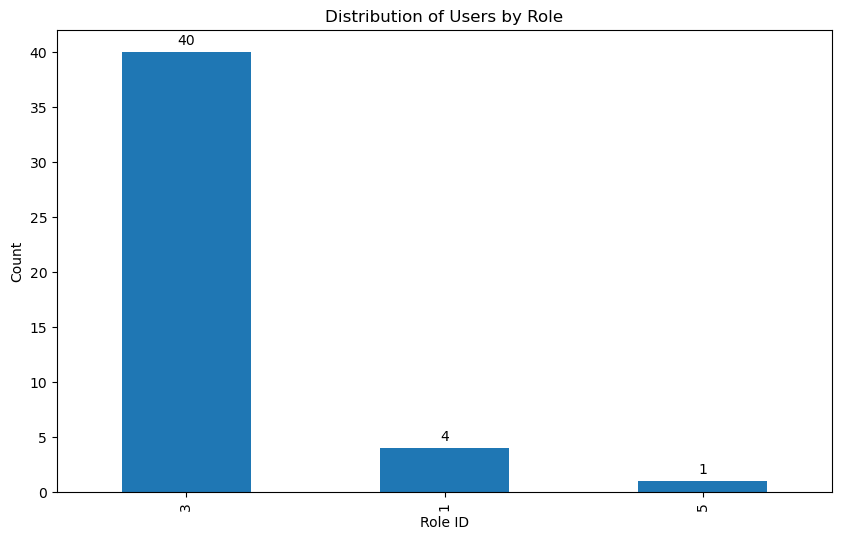

In [80]:
user_role = users_df_cleaned['role_id'].value_counts()

display_graph(user_role, 'Distribution of Users by Role', 'Role ID', 'Count', 10)

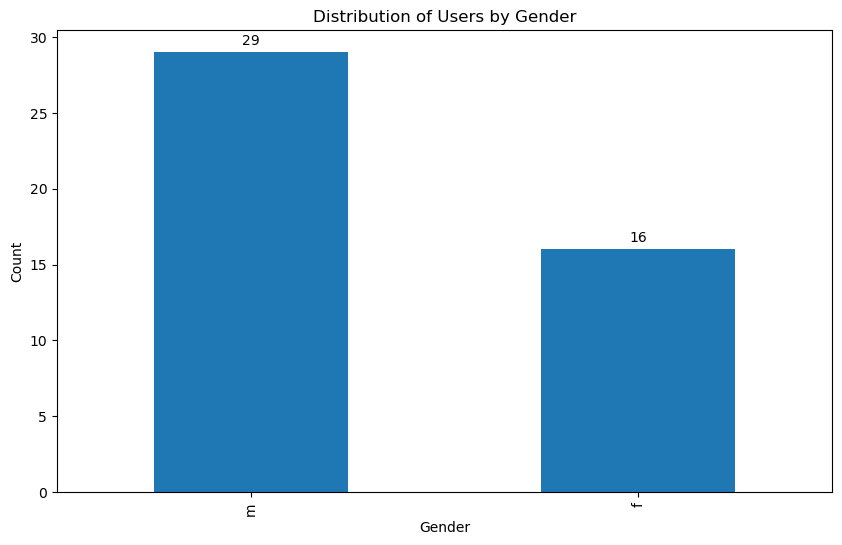

In [81]:
user_gender = users_df_cleaned['gender'].value_counts()

display_graph(user_gender, 'Distribution of Users by Gender', 'Gender', 'Count', 10)

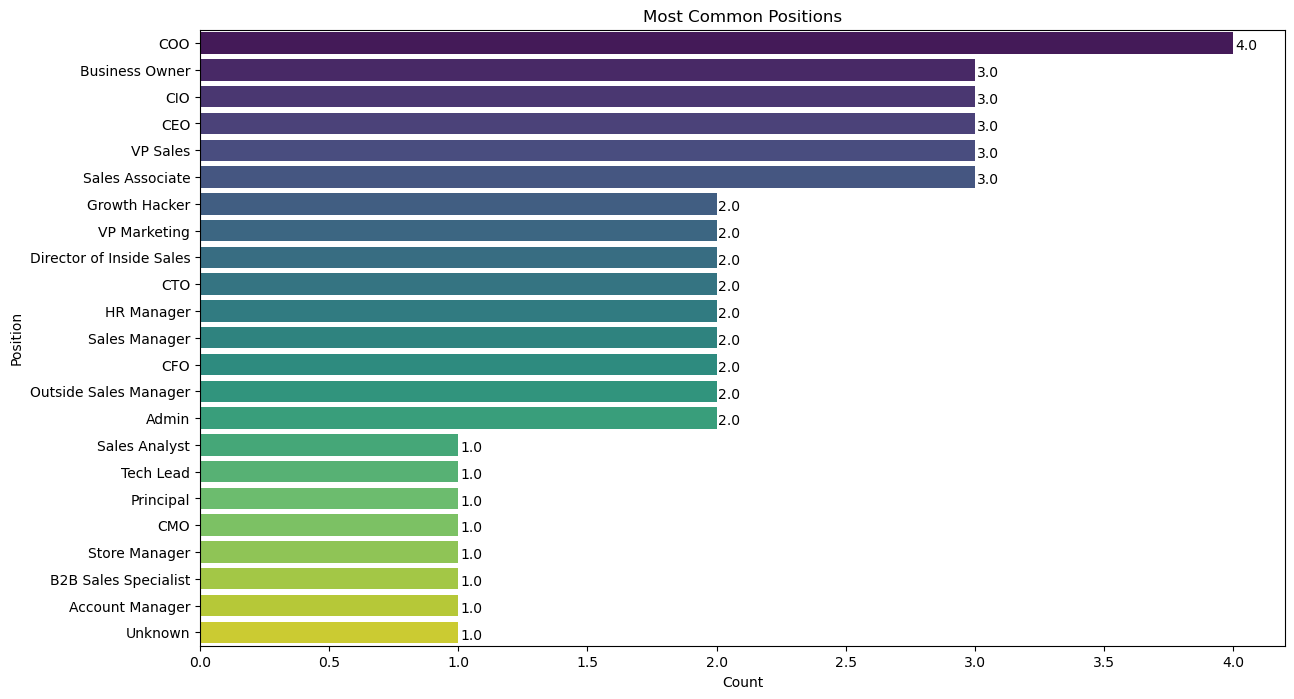

In [82]:
plt.figure(figsize=(14, 8))
ax = sns.countplot(y='position', data=users_df_cleaned, palette='viridis', order=users_df_cleaned['position'].value_counts().index)
plt.title('Most Common Positions')
plt.xlabel('Count')
plt.ylabel('Position')

# Add labels
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_width() + 0.05, p.get_y() + 0.5), ha='center', va='center')

plt.show()